# Pattern Recognition Project

In this mini project, the algorithm should visually diagnose melanoma, the deadliest form of skin cancer. In particular, the algorithm should distinguish this malignant skin tumor from two types of benign lesions (**nevi** and **seborrheic keratoses**).

In [29]:
#Imports
import numpy as np
import cv2
import csv
import codecs
from PIL import Image
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from sklearn import preprocessing
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda
from keras.layers import Convolution2D, MaxPooling2D, Cropping2D
from keras.optimizers import Adamax, Adam, SGD
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Dropout, Activation
from keras.callbacks import ReduceLROnPlateau
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from keras.layers import GlobalAveragePooling2D, Conv2D
from keras.initializers import TruncatedNormal
from keras.regularizers import l1, l2
from get_results import plot_roc_auc, plot_confusion_matrix
import pandas as pd
from keras.callbacks import ModelCheckpoint 

## Reading images

Here we read data from a modified dataset __"not_data"__. In this datasest we have resized the original images to about 480x320.

(426, 320)
(426, 320)
(482, 320)
(224, 224)


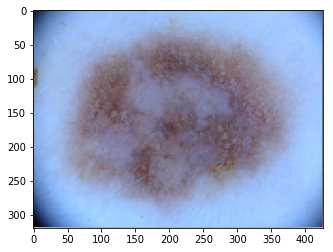

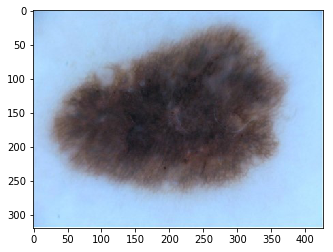

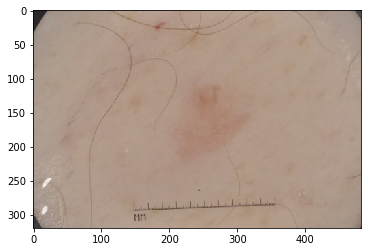

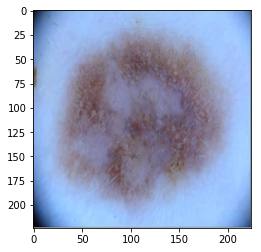

In [2]:
train_path = 'not_data/train/'
valid_path = 'not_data/valid/'
test_path = 'not_data/test/'
width = 224
height = 224

melanoma = Image.open(train_path + "melanoma/ISIC_0000035.jpg")
nevus = Image.open(train_path + "nevus/ISIC_0000000.jpg")
seborrheic_keratosis = Image.open(train_path + "seborrheic_keratosis/ISIC_0012282.jpg")
plt.imshow(melanoma)
print(melanoma.size)
print(nevus.size)
print(seborrheic_keratosis.size)
plt.figure()
plt.imshow(nevus)
plt.figure()
plt.imshow(seborrheic_keratosis)
# Resizing to exactly 224x224
im1 = melanoma.resize((width, height), Image.ANTIALIAS) 
print(im1.size)
plt.figure()
plt.imshow(im1)

## Defining the generator function
As the dataset is quite large we would need a generator function in order to generate the images batchwise.This is helpful if we use the original dataset. But the original dataset was not used as it took a very long time to train because of very large file sizes.

In [3]:
lines_train = []
lines_valid = []
lines_test = []
#codecs.open('file.csv', 'rU', 'utf-16')
# Storing the training paths in a list
reader = csv.reader(codecs.open('./not_data/train/file_names.csv', 'rU', 'utf-16'))
for line in reader:
    lines_train.append(line)

shuffle(lines_train)

# Storing the validation paths in a list
reader = csv.reader(codecs.open('./not_data/valid/file_names.csv', 'rU', 'utf-16'))
for line in reader:
    lines_valid.append(line)

shuffle(lines_valid)

# Storing the testing paths in a list
reader = csv.reader(codecs.open('./not_data/test/file_names.csv', 'rU', 'utf-16'))
for line in reader:
    lines_test.append(line)

shuffle(lines_test)


# Generator for generating the images batchwise.
def myGenerator_train(lines_model, batch_size):
    num_samples = len(lines_model)
    X_return = []
    y_return = []

    while True:
        for offset in range(0, num_samples, batch_size):
            images = []
            target_prediction = []
            temp_line = lines_model[offset:offset+int(batch_size)]

            for index in range(0, len(temp_line)):
                source_path = temp_line[index][0]
                filename = source_path.split('\\')
                current_path = './not_data/train/' + str(filename[0]) + '/' + str(filename[1])

                # Load the center image
                img = Image.open(current_path)
                img.load()
                img = img.resize((width, height), Image.ANTIALIAS) 
                image = np.asarray(img)
                images.append(image)
                prediction_string = source_path.split('\\')[0]
                if prediction_string == "melanoma":
                    prediction = [1,0,0]
                elif prediction_string == "nevus":
                    prediction = [0,1,0]
                elif prediction_string == "seborrheic_keratosis":
                    prediction = [0,0,1]

                target_prediction.append(prediction)


            X_return = np.asarray(images)
            y_return = np.asarray(target_prediction)

#             onehot_encoder = OneHotEncoder(sparse=False)
#             label_encoder = LabelEncoder()
#             integer_encoded = label_encoder.fit_transform(y_return)
#             integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
#             y_return = onehot_encoder.fit_transform(integer_encoded)
#             print(y_return)

            yield shuffle(X_return, y_return)
            
            
def myGenerator_valid(lines_model, batch_size):
    num_samples = len(lines_model)
    X_return = []
    y_return = []

    while True:
        for offset in range(0, num_samples, batch_size):
            images = []
            target_prediction = []
            temp_line = lines_model[offset:offset+int(batch_size)]

            for index in range(0, len(temp_line)):
                source_path = temp_line[index][0]
                filename = source_path.split('\\')
                current_path = './not_data/valid/' + str(filename[0]) + '/' + str(filename[1])

                # Load the center image
                img = Image.open(current_path)
                img.load()
                img = img.resize((width, height), Image.ANTIALIAS) 
                image = np.asarray(img)
                images.append(image)
                prediction_string = source_path.split('\\')[0]
                if prediction_string == "melanoma":
                    prediction = [1,0,0]
                elif prediction_string == "nevus":
                    prediction = [0,1,0]
                elif prediction_string == "seborrheic_keratosis":
                    prediction = [0,0,1]

                
                target_prediction.append(prediction)


            X_return = np.asarray(images)
            y_return = np.asarray(target_prediction)
    
#             onehot_encoder = OneHotEncoder(sparse=False)
#             label_encoder = LabelEncoder()
#             integer_encoded = label_encoder.fit_transform(y_return)
#             integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
#             y_return = onehot_encoder.fit_transform(integer_encoded)

            yield shuffle(X_return, y_return)

### Defining a CNN architecture
Here a basic CNN has been defined in order to get the basic idea of defining a CNN architecture and training a CNN.

In [4]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
model = Sequential()

model.add(Lambda(lambda x:(x/255.0), input_shape=(224,224,3)))
model.add(Convolution2D(16, kernel_size=(5, 5),activation='relu',padding='same',input_shape=(224,224,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (5, 5), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))

#model.add(Dropout(0.25))
#model.add(Flatten())
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.25))
model.add(Dense(3, activation='softmax'))

model.summary()

# model = Sequential()

# model.add(Lambda(lambda x: (x/255.0), input_shape=(224,224,3)))
# #model.add(Cropping2D(cropping=((70,25),(0,0))))
# model.add(Convolution2D(24, (5,5), strides=(2,2), padding='same'))
# #model.add(BatchNormalization())
# model.add(Activation('relu'))
# #model.add(MaxPooling2D())

# model.add(Convolution2D(36, (5,5), strides=(2,2), padding='same'))
# #model.add(BatchNormalization())
# model.add(Activation('relu'))
# #model.add(MaxPooling2D())

# model.add(Convolution2D(48, (5,5), strides=(2,2), padding='same'))
# #model.add(BatchNormalization())
# model.add(Activation('relu'))
# #model.add(MaxPooling2D())

# model.add(Convolution2D(64, (3,3), strides=(2,2), padding='same'))
# #model.add(BatchNormalization())
# model.add(Activation('relu'))
# #model.add(MaxPooling2D())

# model.add(Convolution2D(64, (3,3), strides=(2,2), padding='same'))
# #model.add(BatchNormalization())
# model.add(Activation('relu'))
# #model.add(MaxPooling2D())

# model.add(Flatten())

# model.add(Dropout(0.5))
# model.add(Dense(1164))

# model.add(Dropout(0.5))
# model.add(Dense(100))

# model.add(Dropout(0.5))
# model.add(Dense(50))

# model.add(Dropout(0.6))
# model.add(Dense(3))

# model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 16)      1216      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 32)      12832     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
global_average_pooling2d_1 ( (None, 64)                0         
__________

In [5]:
batch_size = 32
adam = Adamax(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='mse', optimizer=adam)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor = 0.1, patience = 1, verbose = 1,min_lr = 0.000001)

# Modelcheckpointer has not been used as the validation loss keeps on decreasing and never plateaus

print(len(lines_train))
print(len(lines_valid))

train_gen = myGenerator_train(lines_train ,batch_size)
valid_gen = myGenerator_valid(lines_valid, batch_size)


hist = model.fit_generator(train_gen,
                           int((len(lines_train))/batch_size),
                           epochs = 10,verbose=1, 
                           callbacks=[reduce_lr],
                           validation_data = valid_gen,
                           validation_steps = int((len(lines_valid))/batch_size))

2000
150
Epoch 1/10
62/62 [==============================] - 29s - loss: 0.5232 - val_loss: 0.2477
Epoch 2/10
62/62 [==============================] - 8s - loss: 0.2158 - val_loss: 0.1836
Epoch 3/10
62/62 [==============================] - 9s - loss: 0.2083 - val_loss: 0.1872
Epoch 4/10
61/62 [============================>.] - ETA: 0s - loss: 0.1988
Epoch 00003: reducing learning rate to 0.00010000000474974513.
62/62 [==============================] - 9s - loss: 0.2032 - val_loss: 0.1990
Epoch 5/10
61/62 [============================>.] - ETA: 0s - loss: 0.1637
Epoch 00004: reducing learning rate to 1.0000000474974514e-05.
62/62 [==============================] - 9s - loss: 0.1684 - val_loss: 0.1944
Epoch 6/10
61/62 [============================>.] - ETA: 0s - loss: 0.1608
Epoch 00005: reducing learning rate to 1.0000000656873453e-06.
62/62 [==============================] - 8s - loss: 0.1662 - val_loss: 0.1939
Epoch 7/10
62/62 [==============================] - 8s - loss: 0.1654 - val

In [6]:
# Checking for test accuracy

test_size = len(lines_test)
test_predictions = []
target_predictions = []
for index in range(0, test_size):
    source_path = lines_test[index][0]
    filename = source_path.split('\\')
    current_path = './not_data/test/' + str(filename[0]) + '/' + str(filename[1])
    
    img = Image.open(current_path)
    img.load()
    img = img.resize((width, height), Image.ANTIALIAS) 
    img_c = img.copy()
    image = np.asarray(img_c)
    test_predictions.append(np.argmax(model.predict(np.array(image, ndmin = 4))))

    prediction_string = source_path.split('\\')[0]
    
    if prediction_string == "melanoma":
        prediction = [1,0,0]
    elif prediction_string == "nevus":
        prediction = [0,1,0]
    elif prediction_string == "seborrheic_keratosis":
        prediction = [0,0,1]

    target_predictions.append(prediction)
    
test_accuracy = 100*np.sum(np.array(test_predictions)==np.argmax(target_predictions, axis=1))/len(test_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)
print(np.array(test_predictions))
print(np.argmax(target_predictions, axis = 1))

Test accuracy: 65.5000%
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 

We can see here that the neural network underfits very badly. As it only produces yes for all the cases for __"nevus"__. So as we have a small dataset and images that are quite hard to distinguish between each other we use __Transfer Learning__. And also the training dataset has a extremely high number of images related to __"nevus"__ so this leads to the CNN becoming biased.

## Using Transfer Learning

### Creating bottleneck features

In [7]:
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.preprocessing import image
from tqdm import tqdm
from keras.preprocessing.image import ImageDataGenerator

modelTransfer = ResNet50(weights='imagenet', include_top=False)

In [8]:
from keras.models import Model

In [9]:
from matplotlib.pyplot import imshow

# Defining aspect ratio to resize the images
ratio = 0.664179104477612
target_width = 224
target_size = (target_width, round(target_width/ratio))

# Generating random image augmentation to build a robust network
datagen_train = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    rotation_range=30,
    horizontal_flip=True,
    vertical_flip=True
)

def path_to_bottleneck_feature(img_path, argument=0):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=target_size)
   
    # convert PIL.Image.Image type to 3D tensor
    x = image.img_to_array(img)
     
    # convert 3D tensor to 4D tensor with shape (1, ?, ?, 3) and return 4D tensor
    x = np.expand_dims(x, axis=0)
    
    # preprocess input
    x = preprocess_input(x)
    
    if argument > 0:
        ite = datagen_train.flow(x, [0])
        argumented = [ite.next()[0] for i in range(argument)]
        argumented.append(x)
        argumented = np.vstack(argumented)
        return modelTransfer.predict(argumented)

    # prediction applied to one image at time to save memory (a batch imaplementation would have been more optimal)
    return modelTransfer.predict(x)

def paths_to_bottleneck_features(img_paths, argument=0):
    bottleneck_features = []
    paths = []
    for img_path in tqdm(img_paths):
        try:
            bottleneck_features.append(path_to_bottleneck_feature(img_path, argument))
            paths.append(img_path)
        except OSError:
            None 
            
    return paths, np.vstack(bottleneck_features)

In [10]:
import glob
import pickle

datasets = ['test', 'train', 'valid']
diagnoses = ['melanoma', 'nevus', 'seborrheic_keratosis']
diagnose_to_index = {diagnoses[i]: i for i in range(len(diagnoses))}

def get_bottleneck_feature(dataset, argument=[0,0,0]):
    features = []
    labels = []
    img_paths = []
    index = 0
    for diagnose in diagnoses:
        path = "data/{}/{}/*.jpg".format(dataset, diagnose)
        paths = glob.glob(path)

        paths, paths_features = paths_to_bottleneck_features(paths, argument[index])
        index = index + 1
        paths_labels = np.full(len(paths_features), diagnose_to_index[diagnose])
        
        features = paths_features if len(features) == 0 else np.concatenate([features, paths_features])
        labels = paths_labels if len(labels) == 0 else np.concatenate([labels, paths_labels])
        img_paths = paths if len(img_paths) == 0 else np.concatenate([img_paths, paths])

    return features, labels, img_paths



train_x, train_y, _ = get_bottleneck_feature('train', [29,10,49])
valid_x, valid_y, _ = get_bottleneck_feature('valid')
test_x, test_y, test_paths = get_bottleneck_feature('test')

# Dictionary mapping the bottleneck features to strings
bottleneck_feature = {
    'test_x': test_x,
    'test_y': test_y,
    'test_paths': test_paths,
    'train_x': train_x,
    'train_y': train_y,
    'valid_x': valid_x,
    'valid_y': valid_y
}

# Writing the recently extracted bottleneck features
with open('models/bottleneck_feature.pickle', 'wb') as f:
    pickle.dump(bottleneck_feature, f, pickle.HIGHEST_PROTOCOL)

100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:19<00:00,  4.52it/s]


In [11]:
from  keras.utils import to_categorical
import pickle

with open('models/bottleneck_feature.pickle', 'rb') as f:
    bottleneck_feature = pickle.load(f)
    
train_x = bottleneck_feature['train_x']
train_y = to_categorical(bottleneck_feature['train_y'], 3)

valid_x = bottleneck_feature['valid_x']
valid_y = to_categorical(bottleneck_feature['valid_y'], 3)

test_x = bottleneck_feature['test_x']
test_y = to_categorical(bottleneck_feature['test_y'], 3)
test_paths = bottleneck_feature['test_paths']

print(train_x.shape)
print(train_y.shape)
print(valid_x.shape)
print(valid_y.shape)
print(test_x.shape)
print(test_y.shape)

(39012, 1, 1, 2048)
(39012, 3)
(150, 1, 1, 2048)
(150, 3)
(600, 1, 1, 2048)
(600, 3)


In this case we use a CNN called ResNet50. This type of CNN with a total of 152 layers won the 1st place on the ILSVRC 2015 classification task. This neural network has 152 layers and it uses a residual learning framework to ease the training of the network. Here is the model of the network in use:
![NN](resnet34.png)

The pretrained weights that we downloaded do not contain the final fully connected layers. So, we add our own fully connected layers to the model and train the fully connected layers while freezing the weights of the layers above.

### Adding the fully connected layers

In [12]:
model = Sequential()
model.add(Flatten(input_shape=train_x.shape[1:]))
#model.add(Dropout(0.5))
model.add(Dense(3060, activation='relu', kernel_regularizer=l2(0.02)))
#model.add(Dropout(0.5))
model.add(Dense(3060, activation='relu', kernel_regularizer=l2(0.02)))
model.add(Dense(3, activation='softmax'))
model.summary()

# model = Sequential()
# model.add(GlobalAveragePooling2D(input_shape=train_x.shape[1:]))
# model.add(Dropout(0.5))
# model.add(Dense(2048, activation='tanh'))
# model.add(Dropout(0.5))
# model.add(Dense(2048, activation='tanh'))
# model.add(Dense(3, activation='softmax'))
# model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 3060)              6269940   
_________________________________________________________________
dense_3 (Dense)              (None, 3060)              9366660   
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 9183      
Total params: 15,645,783.0
Trainable params: 15,645,783.0
Non-trainable params: 0.0
_________________________________________________________________


### Training the Neural  Network

In [13]:
#adam = Adamax(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.005)
#adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.005)
sgd = SGD(lr=0.0001, momentum=0.9, decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [14]:
checkpointer = ModelCheckpoint(filepath='models/weights.best.hdf5', verbose=1, save_best_only=True)

model.fit(train_x, train_y,validation_data=(valid_x, valid_y), epochs=10, batch_size=32, callbacks=[checkpointer], verbose=1)

Train on 39012 samples, validate on 150 samples
Epoch 1/10


19456/39012 [=============>................] - ETA: 1080s - loss: 111.6243 - acc: 0.21 - ETA: 380s - loss: 111.5421 - acc: 0.2917 - ETA: 202s - loss: 111.4768 - acc: 0.364 - ETA: 142s - loss: 111.4442 - acc: 0.361 - ETA: 112s - loss: 111.4154 - acc: 0.372 - ETA: 94s - loss: 111.3935 - acc: 0.391 - ETA: 82s - loss: 111.3735 - acc: 0.39 - ETA: 73s - loss: 111.3524 - acc: 0.42 - ETA: 67s - loss: 111.3310 - acc: 0.42 - ETA: 62s - loss: 111.3146 - acc: 0.43 - ETA: 58s - loss: 111.2944 - acc: 0.44 - ETA: 55s - loss: 111.2794 - acc: 0.45 - ETA: 52s - loss: 111.2616 - acc: 0.45 - ETA: 49s - loss: 111.2461 - acc: 0.45 - ETA: 47s - loss: 111.2241 - acc: 0.46 - ETA: 46s - loss: 111.2070 - acc: 0.47 - ETA: 43s - loss: 111.1834 - acc: 0.47 - ETA: 42s - loss: 111.1643 - acc: 0.48 - ETA: 41s - loss: 111.1460 - acc: 0.49 - ETA: 40s - loss: 111.1275 - acc: 0.49 - ETA: 39s - loss: 111.1112 - acc: 0.49 - ETA: 38s - loss: 111.0947 - acc: 0.50 - ETA: 37s - loss: 111.0799 - acc: 0.50 - ETA: 36s - loss: 111.


39012/39012 [==============================] - 26s - loss: 105.9126 - acc: 0.6762 - val_loss: 100.8267 - val_acc: 0.7267
Epoch 2/10


39012/39012 [==============================] - 24s - loss: 96.0206 - acc: 0.7478 - val_loss: 91.5177 - val_acc: 0.7267
Epoch 3/10


19616/39012 [==============>...............] - ETA: 30s - loss: 91.2840 - acc: 0.937 - ETA: 26s - loss: 91.3519 - acc: 0.820 - ETA: 25s - loss: 91.3681 - acc: 0.785 - ETA: 24s - loss: 91.3686 - acc: 0.771 - ETA: 24s - loss: 91.3639 - acc: 0.778 - ETA: 23s - loss: 91.3859 - acc: 0.765 - ETA: 24s - loss: 91.3851 - acc: 0.762 - ETA: 24s - loss: 91.3814 - acc: 0.756 - ETA: 23s - loss: 91.3554 - acc: 0.764 - ETA: 23s - loss: 91.3458 - acc: 0.758 - ETA: 23s - loss: 91.3304 - acc: 0.762 - ETA: 23s - loss: 91.3234 - acc: 0.759 - ETA: 23s - loss: 91.3129 - acc: 0.760 - ETA: 23s - loss: 91.3026 - acc: 0.762 - ETA: 23s - loss: 91.2895 - acc: 0.761 - ETA: 23s - loss: 91.2756 - acc: 0.762 - ETA: 23s - loss: 91.2620 - acc: 0.765 - ETA: 23s - loss: 91.2489 - acc: 0.763 - ETA: 23s - loss: 91.2383 - acc: 0.763 - ETA: 23s - loss: 91.2289 - acc: 0.763 - ETA: 23s - loss: 91.2164 - acc: 0.762 - ETA: 22s - loss: 91.2058 - acc: 0.762 - ETA: 22s - loss: 91.1933 - acc: 0.763 - ETA: 22s - loss: 91.1786 - acc: 0

39012/39012 [==============================] - 25s - loss: 87.1215 - acc: 0.7789 - val_loss: 83.0825 - val_acc: 0.7067
Epoch 4/10


39012/39012 [==============================] - 24s - loss: 79.0698 - acc: 0.7997 - val_loss: 75.4662 - val_acc: 0.7400
Epoch 5/10


19552/39012 [==============>...............] - ETA: 24s - loss: 75.2413 - acc: 0.875 - ETA: 23s - loss: 75.2767 - acc: 0.820 - ETA: 24s - loss: 75.2696 - acc: 0.817 - ETA: 23s - loss: 75.2556 - acc: 0.821 - ETA: 23s - loss: 75.2331 - acc: 0.838 - ETA: 23s - loss: 75.2312 - acc: 0.826 - ETA: 23s - loss: 75.2207 - acc: 0.832 - ETA: 23s - loss: 75.2137 - acc: 0.826 - ETA: 23s - loss: 75.1989 - acc: 0.831 - ETA: 23s - loss: 75.1919 - acc: 0.829 - ETA: 23s - loss: 75.1826 - acc: 0.829 - ETA: 23s - loss: 75.1768 - acc: 0.827 - ETA: 23s - loss: 75.1730 - acc: 0.825 - ETA: 22s - loss: 75.1644 - acc: 0.824 - ETA: 23s - loss: 75.1535 - acc: 0.827 - ETA: 23s - loss: 75.1451 - acc: 0.826 - ETA: 22s - loss: 75.1350 - acc: 0.827 - ETA: 22s - loss: 75.1276 - acc: 0.825 - ETA: 22s - loss: 75.1152 - acc: 0.829 - ETA: 22s - loss: 75.1073 - acc: 0.827 - ETA: 22s - loss: 75.0974 - acc: 0.826 - ETA: 22s - loss: 75.0896 - acc: 0.824 - ETA: 22s - loss: 75.0825 - acc: 0.824 - ETA: 22s - loss: 75.0733 - acc: 0

39012/39012 [==============================] - 24s - loss: 71.7800 - acc: 0.8153 - val_loss: 68.5331 - val_acc: 0.7200
Epoch 6/10


39012/39012 [==============================] - 24s - loss: 65.1746 - acc: 0.8264 - val_loss: 62.2935 - val_acc: 0.7267
Epoch 7/10


19520/39012 [==============>...............] - ETA: 31s - loss: 62.2805 - acc: 0.593 - ETA: 26s - loss: 62.1377 - acc: 0.757 - ETA: 25s - loss: 62.0894 - acc: 0.794 - ETA: 24s - loss: 62.0887 - acc: 0.787 - ETA: 24s - loss: 62.0786 - acc: 0.798 - ETA: 23s - loss: 62.0652 - acc: 0.806 - ETA: 24s - loss: 62.0613 - acc: 0.802 - ETA: 23s - loss: 62.0431 - acc: 0.815 - ETA: 23s - loss: 62.0384 - acc: 0.816 - ETA: 23s - loss: 62.0345 - acc: 0.817 - ETA: 23s - loss: 62.0240 - acc: 0.819 - ETA: 23s - loss: 62.0129 - acc: 0.822 - ETA: 23s - loss: 62.0021 - acc: 0.823 - ETA: 23s - loss: 61.9998 - acc: 0.820 - ETA: 23s - loss: 61.9975 - acc: 0.816 - ETA: 23s - loss: 61.9921 - acc: 0.817 - ETA: 23s - loss: 61.9873 - acc: 0.817 - ETA: 23s - loss: 61.9790 - acc: 0.816 - ETA: 23s - loss: 61.9675 - acc: 0.819 - ETA: 23s - loss: 61.9619 - acc: 0.818 - ETA: 22s - loss: 61.9556 - acc: 0.817 - ETA: 22s - loss: 61.9462 - acc: 0.820 - ETA: 22s - loss: 61.9338 - acc: 0.821 - ETA: 22s - loss: 61.9297 - acc: 0

39012/39012 [==============================] - 24s - loss: 59.1891 - acc: 0.8397 - val_loss: 56.5816 - val_acc: 0.7333
Epoch 8/10


39012/39012 [==============================] - 24s - loss: 53.7658 - acc: 0.8455 - val_loss: 51.4472 - val_acc: 0.7400
Epoch 9/10


19616/39012 [==============>...............] - ETA: 26s - loss: 51.0855 - acc: 0.906 - ETA: 24s - loss: 51.1391 - acc: 0.914 - ETA: 24s - loss: 51.1786 - acc: 0.892 - ETA: 24s - loss: 51.1723 - acc: 0.884 - ETA: 24s - loss: 51.1763 - acc: 0.867 - ETA: 23s - loss: 51.1574 - acc: 0.880 - ETA: 23s - loss: 51.1517 - acc: 0.883 - ETA: 23s - loss: 51.1522 - acc: 0.882 - ETA: 23s - loss: 51.1405 - acc: 0.885 - ETA: 23s - loss: 51.1417 - acc: 0.886 - ETA: 23s - loss: 51.1431 - acc: 0.880 - ETA: 23s - loss: 51.1408 - acc: 0.875 - ETA: 23s - loss: 51.1364 - acc: 0.870 - ETA: 23s - loss: 51.1306 - acc: 0.868 - ETA: 23s - loss: 51.1258 - acc: 0.869 - ETA: 23s - loss: 51.1186 - acc: 0.870 - ETA: 23s - loss: 51.1193 - acc: 0.863 - ETA: 23s - loss: 51.1113 - acc: 0.863 - ETA: 22s - loss: 51.1034 - acc: 0.862 - ETA: 22s - loss: 51.0932 - acc: 0.864 - ETA: 22s - loss: 51.0869 - acc: 0.864 - ETA: 22s - loss: 51.0812 - acc: 0.865 - ETA: 22s - loss: 51.0788 - acc: 0.864 - ETA: 22s - loss: 51.0747 - acc: 0

39012/39012 [==============================] - 24s - loss: 48.8475 - acc: 0.8546 - val_loss: 46.7779 - val_acc: 0.7600
Epoch 10/10


39012/39012 [==============================] - 24s - loss: 44.3882 - acc: 0.8622 - val_loss: 42.5549 - val_acc: 0.7467


In [15]:
# Saving the model weights for later use
model.save_weights('models/weights.hdf5')

### Test accuracy

In [16]:
model.load_weights('models/weights.hdf5')

predictions = [np.argmax(model.predict(np.expand_dims(feature, axis=0))) for feature in test_x]

test_accuracy = 100*np.sum(np.array(predictions)==np.argmax(test_y, axis=1))/len(predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 73.0000%


### Analizing how the network performed in task_1 and task_2

task_1 represents the model's predicted probability that the image depicts melanoma.  
task_2 represents the model's predicted probability that the image depicts seborrheic keratosis.

In [31]:
#print("task 1 represents the model's predicted probability that the image depicts melanoma")
#print("task 2 represents the model's predicted probability that the image depicts seborrheic keratosis")

# Writing the predictied lables of "melanoma" and "seborrheic keratosis" to sample_submission.csv
pred = model.predict(test_x)
with open('sample_submission.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['Id','task_1','task_2'])
    for i in range(len(pred)): 
        writer.writerow([test_paths[i], pred[i,0], pred[i,2]])

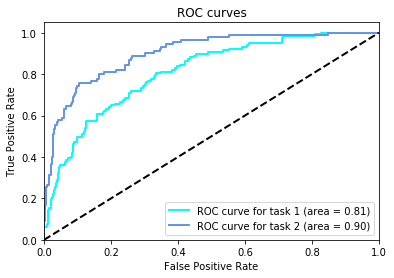

Category 1 Score: 0.809
Category 2 Score: 0.901
Category 3 Score: 0.855


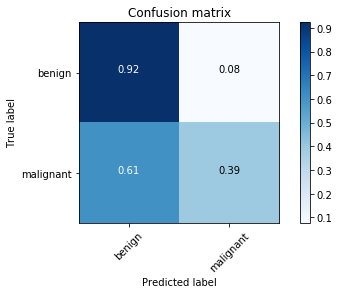

task 1 represents the model's predicted probability that the image depicts melanoma
task 2 represents the model's predicted probability that the image depicts seborrheic keratosis


In [27]:
thresh = 0.5
    
# Ground truth labels for test dataset
truth = pd.read_csv('ground_truth.csv')
y_true = truth.as_matrix(columns=["task_1", "task_2"])

# Predictions for test dataset
y_pred = pd.read_csv('sample_submission.csv')
y_pred = y_pred.as_matrix(columns=["task_1", "task_2"])

# Plot ROC curves and print scores
plot_roc_auc(y_true, y_pred)
# Plotting confusion matrix
classes = ['benign', 'malignant']
plot_confusion_matrix(y_true[:,0], y_pred[:,0], thresh, classes)

![NN](confusion-matrix.png)
__True Positive Rate__ = TRUE POSITIVES / ALL POSITIVES  
__False Positive Rate__ = FALSE POSITIVES / ALL NEGATIVES